In [140]:
import pandas as pd
from utils import get_repo_root
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Set working directory to repo root

In [ ]:
repo_root = get_repo_root()

In [7]:
str(repo_root)

'/Users/batuhansaritas/Desktop/repositories/ing-datathon-team-guney-kampus'

In [ ]:
cust_hist = pd.read_csv(str(repo_root) + '/data/customer_history.csv')
cust = pd.read_csv(str(repo_root) + '/data/customers.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')
sample_sub = pd.read_csv(str(repo_root) + '/data/sample_submission.csv')

## Data Validity  

Customer History

In [44]:
cust_hist.head(10)

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt
0,0,2016-01-01,1.0,2,151.20,NaN,NaN
1,0,2016-02-01,1.0,2,178.70,NaN,NaN
2,0,2016-03-01,2.0,2,37.38,NaN,NaN
3,0,2016-04-01,4.0,2,100.90,NaN,NaN
4,0,2016-05-01,3.0,3,132.28,NaN,NaN
5,0,2016-06-01,1.0,2,79.86,NaN,NaN
6,0,2016-07-01,1.0,2,121.27,NaN,NaN
7,0,2016-08-01,4.0,2,31.54,NaN,NaN
8,0,2016-09-01,4.0,2,93.80,NaN,NaN
9,0,2016-10-01,5.0,2,52.01,NaN,NaN


In [ ]:
# Group by date and count unique customers and total rows
unique_cust_count = cust_hist.groupby('date')['cust_id'].nunique()
row_count = cust_hist.groupby('date').size()

# Combine into a dataframe
customer_count_check_df = pd.DataFrame({
    'unique_cust_count': unique_cust_count,
    'row_count': row_count
}).reset_index()

customer_count_check_df['is_deduplicated?'] = ((customer_count_check_df['row_count'] - customer_count_check_df['unique_cust_count']) == 0)
# Display the result
customer_count_check_df.head()

,date,unique_cust_count,row_count,is_deduplicated?
0,2016-01-01,176293,176293,True
1,2016-02-01,176293,176293,True
2,2016-03-01,176293,176293,True
3,2016-04-01,176293,176293,True
4,2016-05-01,176293,176293,True


In [32]:
# Create a DataFrame to store data quality check results
quality_check = []

# Get numeric columns from cust_hist
numeric_cols = cust_hist.select_dtypes(include=['number']).columns

# Check each numeric column for negative values and NaNs
for col in numeric_cols:
    # Count negative values (less than zero)
    neg_count = (cust_hist[col] < 0).sum()
    
    # Count NaN values
    nan_count = cust_hist[col].isna().sum()
    
    quality_check.append({
        'column_name': col,
        'negative_value_error': neg_count,
        'empty_data': nan_count
    })

# Convert to DataFrame
quality_check_df = pd.DataFrame(quality_check)

# Display the results
quality_check_df

,column_name,negative_value_error,empty_data
0,cust_id,0,0
1,mobile_eft_all_cnt,0,112334
2,active_product_category_nbr,0,0
3,mobile_eft_all_amt,0,112334
4,cc_transaction_all_amt,0,166746
5,cc_transaction_all_cnt,0,166746


Customers

In [46]:
cust.head(10)

,cust_id,gender,age,province,religion,work_type,work_sector,tenure
0,0,F,64,NOH,U,Part-time,Technology,135
1,1,F,57,ZUI,O,Full-time,Finance,65
2,2,F,62,NOB,M,Self-employed,Healthcare,224
3,3,F,22,ZUI,C,Student,NaN,47
4,5,M,27,ZUI,U,Full-time,Finance,108
5,6,F,40,NOH,U,Unemployed,NaN,187
6,7,F,64,GEL,U,Part-time,Public Sector,218
7,8,F,35,ZUI,J,Part-time,Retail,184
8,9,M,52,GRO,C,Full-time,Healthcare,216
9,10,F,31,FLE,M,Full-time,Manufacturing,156


In [50]:
# Create a dataframe to store data quality check results
cust_quality_checks = []

# Check 1: Row count equals unique customer count
total_rows = len(cust)
unique_cust_count = cust['cust_id'].nunique()
cust_quality_checks.append({
    'check_name': 'Row count equals unique cust_id count',
    'sanity': total_rows == unique_cust_count,
    'details': f"Total rows: {total_rows}, Unique cust_ids: {unique_cust_count}"
})

# Check 2: Age is lower than tenure/12 (tenure in months, age in years)
invalid_age_count = (cust['age'] < (cust['tenure'] / 12)).sum()
cust_quality_checks.append({
    'check_name': 'Age less than tenure/12',
    'sanity': invalid_age_count == 0,
    'details': f"{invalid_age_count} customers age < tenure in years"
})

# Check 3: NaN values in various fields
for col in cust.columns:
    nan_count = cust[col].isna().sum()
    cust_quality_checks.append({
        'check_name': f'NaN check for {col}',
        'sanity': nan_count == 0,
        'details': f"Found {nan_count} NaN values in {col}" if nan_count > 0 else "No NaN values"
    })

# Create the quality check dataframe
cust_quality_df = pd.DataFrame(cust_quality_checks)

# Display the results with colored styling for better readability
cust_quality_df

,check_name,sanity,details
0,Row count equals unique cust_id count,True,"Total rows: 176293, Unique cust_ids: 176293"
1,Age less than tenure/12,True,0 customers age < tenure in years
2,NaN check for cust_id,True,No NaN values
3,NaN check for gender,True,No NaN values
4,NaN check for age,True,No NaN values
5,NaN check for province,True,No NaN values
6,NaN check for religion,True,No NaN values
7,NaN check for work_type,True,No NaN values
8,NaN check for work_sector,False,Found 30134 NaN values in work_sector
9,NaN check for tenure,True,No NaN values


Exploration

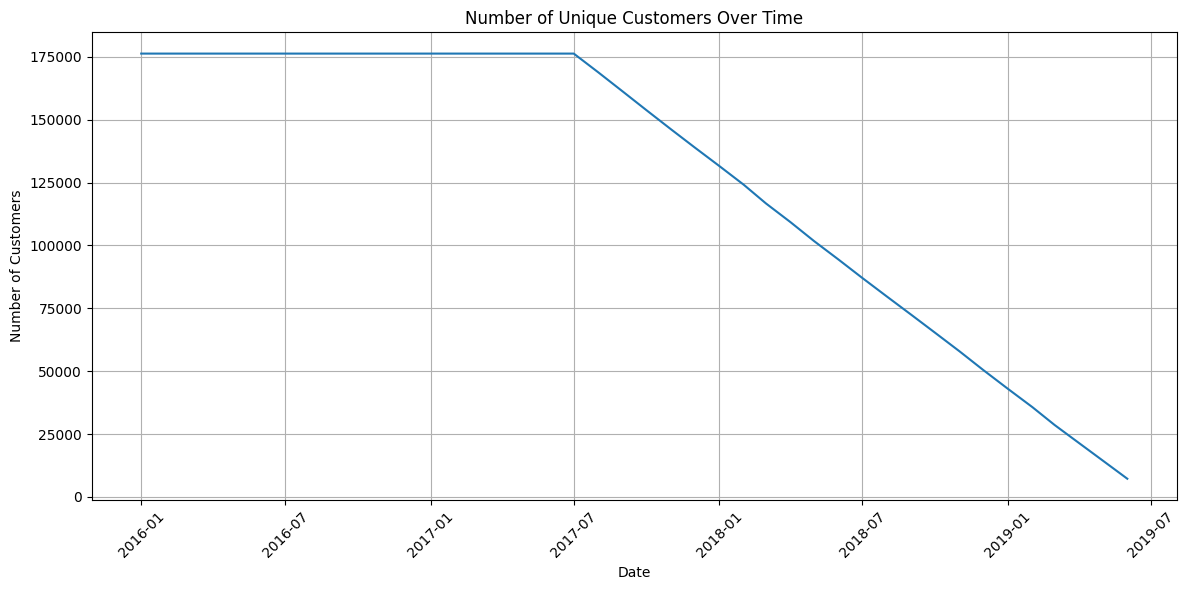

In [ ]:
# Convert date to datetime format
cust_hist['date'] = pd.to_datetime(cust_hist['date'])

# Group by date and count unique customers
customers_per_date = cust_hist.groupby('date')['cust_id'].nunique().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(customers_per_date['date'], customers_per_date['cust_id'])
plt.title('Number of Unique Customers w/ Transaction Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Define the numerical columns to analyze
numerical_cols = ['mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']

# Create a copy of the dataframe and replace NaNs with zeros
cust_hist_filled = cust_hist.copy()
cust_hist_filled[numerical_cols] = cust_hist_filled[numerical_cols].fillna(0)

# Calculate statistics grouped by date for all numerical columns
stats_df = cust_hist_filled.groupby('date')[numerical_cols].agg(['mean', 'max', 'min', 'median'])

# Display the first few rows of the results
stats_df.head()

mobile_eft_all_cnt                   active_product_category_nbr  \
                         mean   max  min median                        mean   
date                                                                          
2016-01-01           3.032917  70.0  0.0    1.0                    2.476287   
2016-02-01           2.998883  73.0  0.0    1.0                    2.476003   
2016-03-01           2.733846  69.0  0.0    1.0                    2.476389   
2016-04-01           2.726586  70.0  0.0    1.0                    2.757659   
2016-05-01           2.803866  70.0  0.0    1.0                    2.758215   

                          mobile_eft_all_amt                        \
           max min median               mean       max  min median   
date                                                                 
2016-01-01   5   2    2.0         409.563023  17594.90  0.0  67.07   
2016-02-01   5   2    2.0         504.557891  18203.78  0.0  83.45   
2016-03-01   5   2    2.0         485.710474  17007.50  0.0  80.11   
2016-04-01   5   2    3.0         528.773372  17193.37  0.0  87.82   
2016-05-01   5   2    3.0         483.676644  17988.58  0.0  81.20   

           cc_transaction_all_amt                        \
                             mean       max  min median   
date                                                      
2016-01-01             474.861201  19083.40  0.0  72.16   
2016-02-01             563.634078  20609.84  0.0  87.38   
2016-03-01             558.708763  19827.71  0.0  86.10   
2016-04-01             536.391656  20649.24  0.0  82.76   
2016-05-01             476.597338  20588.14  0.0  74.72   

           cc_transaction_all_cnt                     
                             mean    max  min median  
date                                                  
2016-01-01              17.863466  271.0  0.0   10.0  
2016-02-01              19.663095  280.0  0.0   11.0  
2016-03-01              18.482299  277.0  0.0   11.0  
2016-04-01              20.326111  282.0  0.0   11.0  
2016-05-01              18.787694  291.0  0.0   11.0

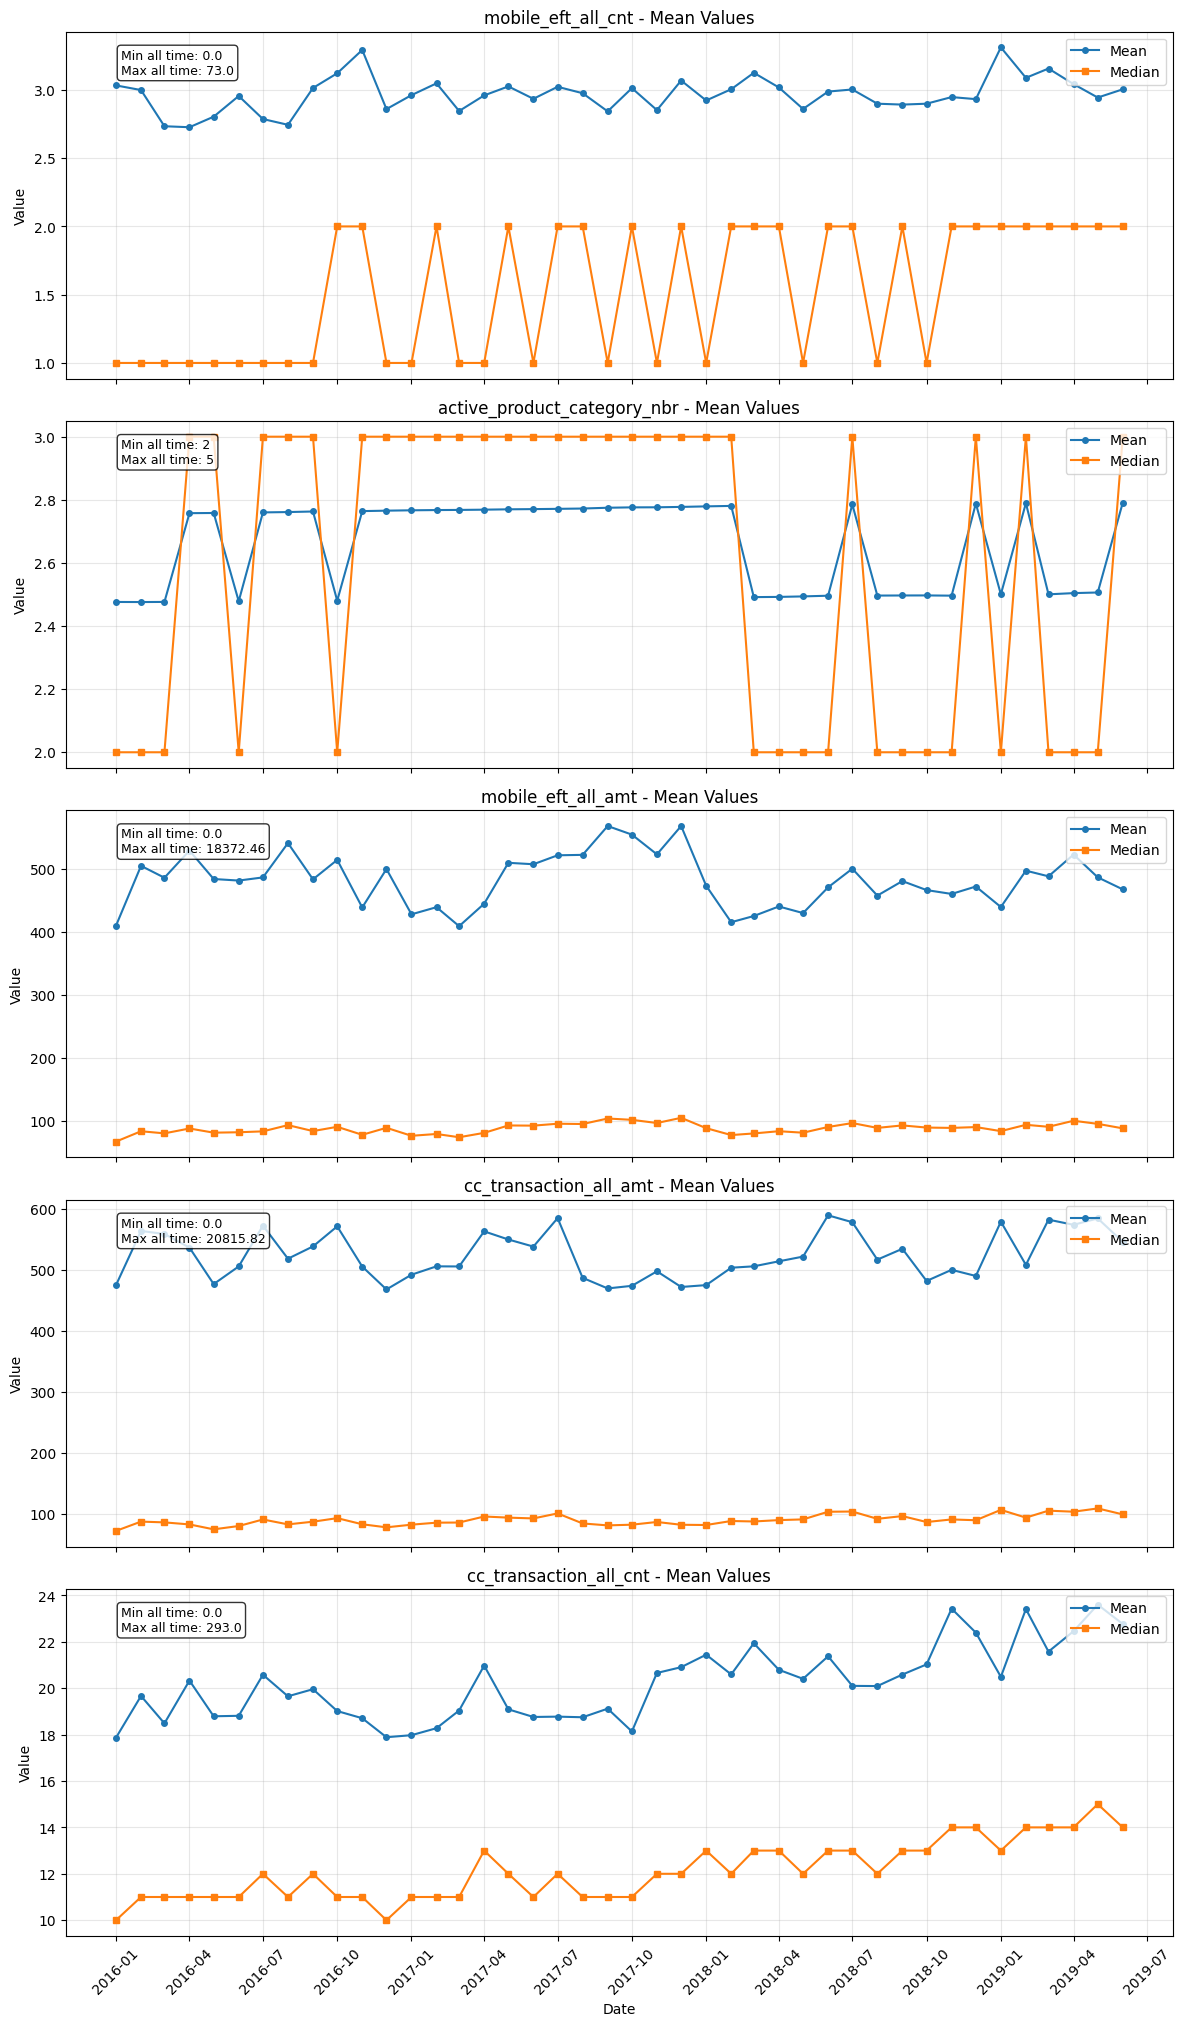

In [ ]:
# Set up the figure with subplots - one for each metric
metrics = ['mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot mean and median
    ax.plot(stats_df.index, stats_df[(metric, 'mean')], label='Mean', marker='o', markersize=4)
    ax.plot(stats_df.index, stats_df[(metric, 'median')], label='Median', marker='s', markersize=4)
    
    # Add title and labels
    ax.set_title(f'{metric} - Mean Values', fontsize=12)
    ax.set_ylabel('Value')
    if i == len(metrics) - 1:  # Only for the bottom subplot
        ax.set_xlabel('Date')
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Find min and max values
    min_val = stats_df[(metric, 'min')].min()
    max_val = stats_df[(metric, 'max')].max()
    
    # Add min-max as text box
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, f"Min all time: {min_val}\nMax all time: {max_val}", transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    # Add legend
    ax.legend(loc='upper right')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

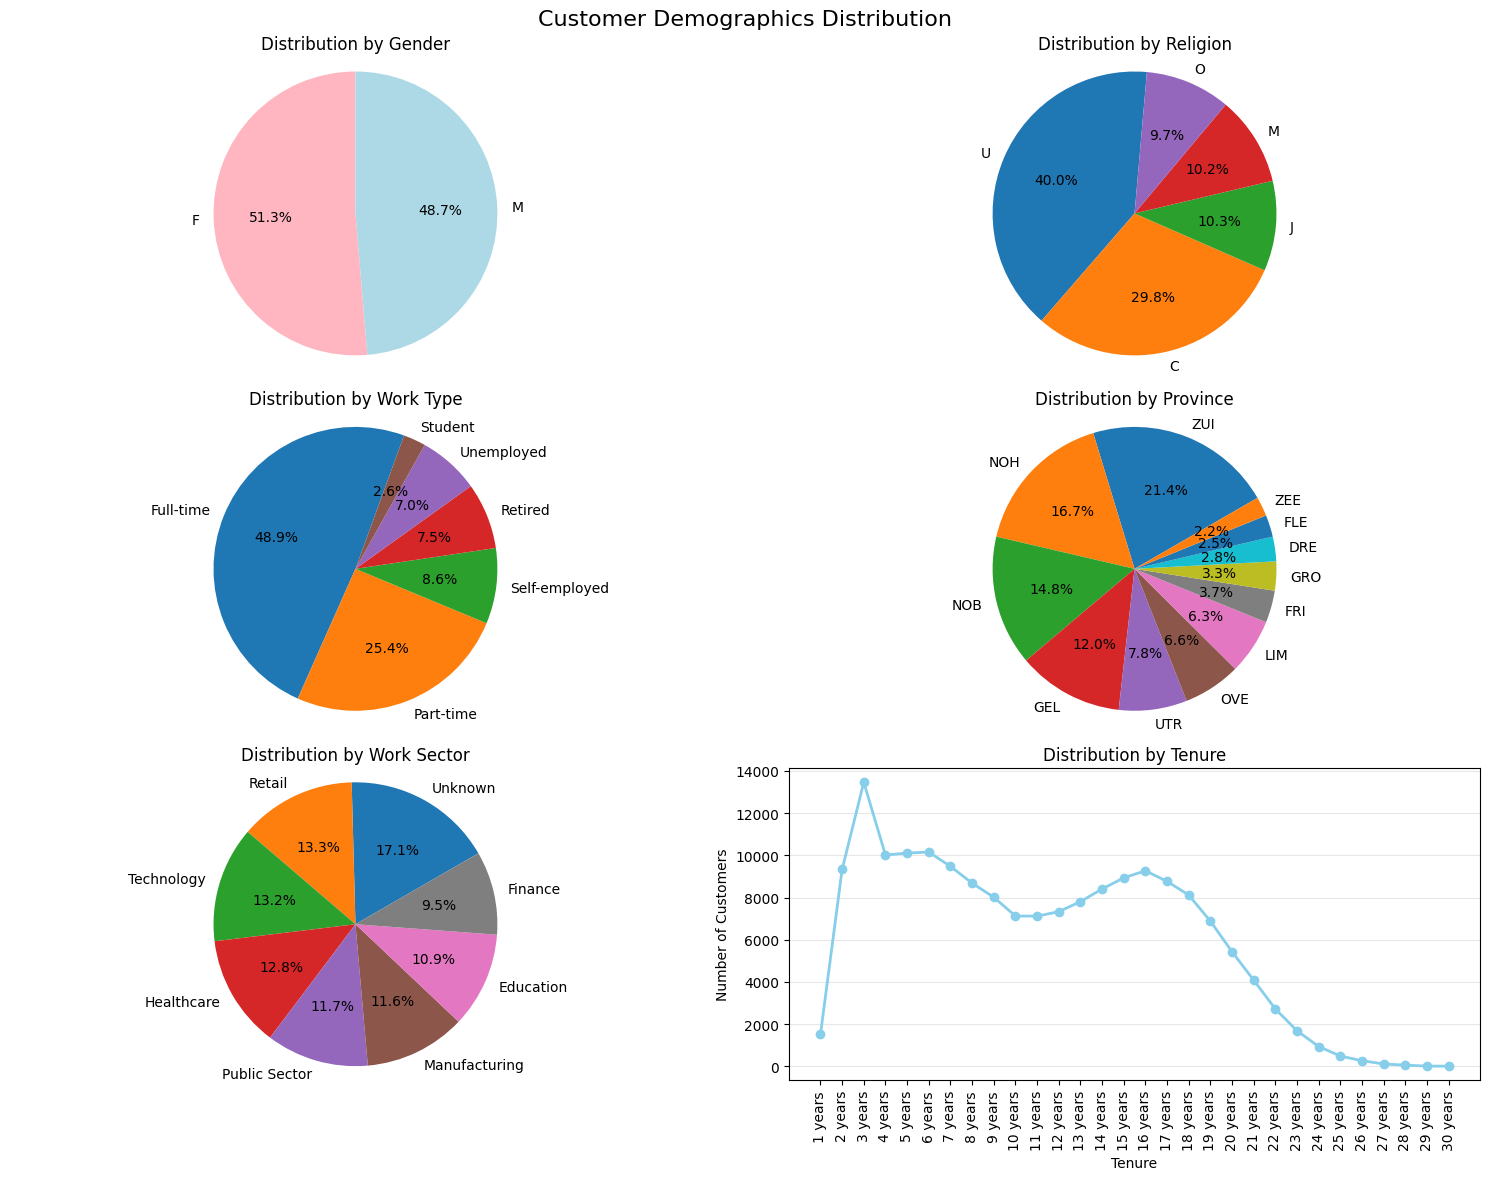

In [ ]:
# Create a figure with subplots for different categorical variables
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot gender distribution
gender_counts = cust['gender'].value_counts()
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightpink', 'lightblue'])
axes[0].set_title('Distribution by Gender')
axes[0].axis('equal')

# Plot religion distribution
religion_counts = cust['religion'].value_counts()
axes[1].pie(religion_counts, labels=religion_counts.index, autopct='%1.1f%%', startangle=85)
axes[1].set_title('Distribution by Religion')
axes[1].axis('equal')

# Plot work_type distribution
work_type_counts = cust['work_type'].value_counts()
axes[2].pie(work_type_counts, labels=work_type_counts.index, autopct='%1.1f%%', startangle=70)
axes[2].set_title('Distribution by Work Type')
axes[2].axis('equal')

# Plot province distribution
province_counts = cust['province'].value_counts()
axes[3].pie(province_counts, labels=province_counts.index, autopct='%1.1f%%', startangle=30)
axes[3].set_title('Distribution by Province')
axes[3].axis('equal')

# Plot work sector distribution
work_sector = cust['work_sector'].fillna('Unknown').value_counts()
axes[4].pie(work_sector, labels=work_sector.index, autopct='%1.1f%%', startangle=30)
axes[4].set_title('Distribution by Work Sector')
axes[4].axis('equal')

# Bar chart (your existing one)
tenure = (cust['tenure'] // 12).value_counts().sort_index()
tenure.index = tenure.index.astype(str) + ' years'

# Line chart (instead of pie chart)
axes[5].plot(tenure.index, tenure.values, marker='o', color='skyblue', linewidth=2)
axes[5].set_title('Distribution by Tenure')
axes[5].set_xlabel('Tenure')
axes[5].set_ylabel('Number of Customers')
axes[5].grid(True, axis='y', alpha=0.3)
axes[5].tick_params(axis='x', rotation=90)


plt.suptitle('Customer Demographics Distribution', fontsize=16)
plt.tight_layout()
plt.show()

What does churn mean?

In [143]:
ref

,cust_id,ref_date,churn
0,0,2017-09-01,0
1,3,2018-10-01,0
2,5,2018-03-01,1
3,6,2018-04-01,1
4,7,2018-05-01,0
...,...,...,...
133282,199995,2018-09-01,0
133283,199996,2018-06-01,0
133284,199997,2018-12-01,0
133285,199998,2018-02-01,1


Text(0.5, 1.0, 'Churn Distribution')

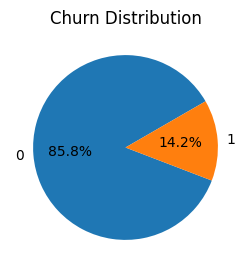

In [149]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))


churn = ref['churn'].value_counts()
axes.pie(churn, labels=churn.index, autopct='%1.1f%%', startangle=30)
axes.set_title('Churn Distribution')

In [136]:
ref.cust_id.nunique()

133287

In [130]:
cust_hist_with_ref = cust_hist.merge(ref, on='cust_id', how='inner', suffixes=('', '_ref'))
cust_hist_with_ref = cust_hist_with_ref[~cust_hist_with_ref.index.duplicated(keep='first')]

In [131]:
cust_hist_with_ref

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,churn
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01,0
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01,0
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01,0
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01,0
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01,0
...,...,...,...,...,...,...,...,...,...
3660870,199999,2018-02-01,0.0,2,0.00,9.66,1.0,2018-06-01,0
3660871,199999,2018-03-01,0.0,2,0.00,22.89,2.0,2018-06-01,0
3660872,199999,2018-04-01,0.0,2,0.00,48.96,3.0,2018-06-01,0
3660873,199999,2018-05-01,0.0,2,0.00,38.20,2.0,2018-06-01,0


Churn olarak taglendiği halde referance date  **ayından sonra** customer history'de datası olan kullanıcı

In [114]:
cust_hist_with_ref.loc[(cust_hist_with_ref.churn == 1) & (cust_hist_with_ref.ref_date < cust_hist_with_ref.date), :]

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,churn


Churn olarak taglendiği halde referance date **ayı içerisinde** customer history'de datası olan kullanıcı

In [116]:
cust_hist_with_ref.loc[(cust_hist_with_ref.churn == 1) & (cust_hist_with_ref.ref_date == cust_hist_with_ref.date), :]

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,churn
81,5,2018-03-01,4.0,2,723.01,13.74,3.0,2018-03-01,1
109,6,2018-04-01,6.0,2,262.55,11.06,1.0,2018-04-01,1
320,16,2017-10-01,1.0,3,51.78,316.16,52.0,2017-10-01,1
376,18,2017-08-01,0.0,3,0.00,12.07,4.0,2017-08-01,1
437,22,2018-01-01,1.0,3,9.69,42.82,10.0,2018-01-01,1
...,...,...,...,...,...,...,...,...,...
3659840,199956,2017-08-01,5.0,3,826.65,10.49,1.0,2017-08-01,1
3660118,199969,2017-12-01,1.0,2,79.56,401.27,20.0,2017-12-01,1
3660246,199973,2018-10-01,1.0,3,23.35,208.22,20.0,2018-10-01,1
3660547,199988,2018-01-01,0.0,2,0.00,12.04,5.0,2018-01-01,1


In [162]:
summary_ = pd.DataFrame({
    "number of customers in ref dataset": [ref['cust_id'].nunique()],
    "number of customers in ref test dataset": [ref_test['cust_id'].nunique()],
    "number of customers in total": [cust['cust_id'].nunique()]
})

summary_

summary_


,number of customers in ref dataset,number of customers in ref test dataset,number of customers in total
0,133287,43006,176293
